In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# import SummaryWriter
from torch.utils.tensorboard import SummaryWriter

# import the MNIST dataset
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

import torchsummary

from sklearn.model_selection import train_test_split

# from torchdiffeq import odeint, odeint_adjoint

import cv2
import numpy as np

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from tqdm.notebook import trange

In [2]:
from src.models.ae import ConvAE, ConvAEwithResNet

In [3]:
from src.utils.utils import add_spatial_encoding
from src.data.ball import Image, move_fun_circle

In [4]:
dt = 0.01
frames = 4000

image_generator = Image(np.array([1., 1.], dtype=np.float64), 3., lambda t,x: move_fun_circle(t,x, w=10, exp_decay=0.1), size=28, border=(-2., 2.))
samples = image_generator.generate_samples(dt, frames=frames, conv=True)
positions = image_generator.generate_trajectory_positions(dt, frames=frames)
samples = [(image,0) for image in samples]
dataset = add_spatial_encoding(samples)
dataset = torch.from_numpy(np.array([image for image, _ in dataset])).float()
dataset.shape

torch.Size([4000, 3, 28, 28])

In [20]:
# path of the model
latent = 3
# path = "models/AE/ae_1_Ball_with_sp_latent_{}.pth".format(latent)
path = "models/AE/ae_1_Ball_with_sp_latent_{}_no_relu.pth".format(latent)
# pathResNet = "models/AE/ae_resnet18_1_Ball_with_sp_latent_{}.pth".format(latent)

In [21]:
ae = ConvAE(height=28, width=28, latent_dim=latent, in_channels=3, relu=False)
ae.load_state_dict(torch.load(path))

# ae = ConvAEwithResNet(height=28, width=28, latent_dim=latent, in_channels=3)
# ae.load_state_dict(torch.load(pathResNet))

# freeze every parameters
for param in ae.parameters():
    param.requires_grad = False

Number of parameters in the model: 225318


In [22]:
encoded_whole_trajectory = ae.encode(dataset)

In [23]:
encoded_whole_trajectory.shape

torch.Size([4000, 3])

In [24]:
encoded_trajectory = encoded_whole_trajectory #[:frames//2]

In [25]:
# using t-SNE to tranform the encoded trajectory to 2D trajectory
from sklearn.manifold import TSNE

# using the PCA method to reduce the dimensionality of the encoded trajectory
from sklearn.decomposition import PCA

import pacmap

tsne_model = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000)
tsne_trajectory = tsne_model.fit_transform(encoded_trajectory.detach().numpy())
print(tsne_trajectory.shape)

pca_model = PCA(n_components=2)
pca_trajectory = pca_model.fit_transform(encoded_trajectory.detach().numpy())
print(pca_trajectory.shape)

pacmap_model = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
pacmap_trajectory = pacmap_model.fit_transform(encoded_trajectory.detach().numpy(), init="pca")

/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(4000, 2)
(4000, 2)


(4000, 2)
(4000, 2)


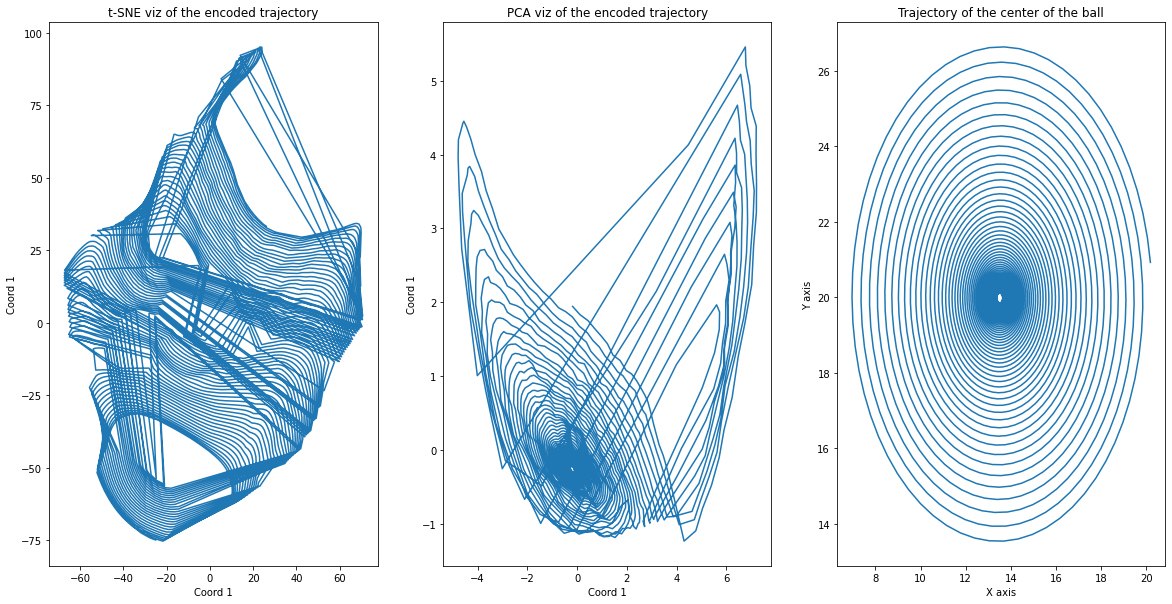

In [26]:
def plot_tsne(tsne_encoded_trajectory, pca_encoded_trajectory, positions):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(131)
    ax.plot(tsne_encoded_trajectory[:, 0], tsne_encoded_trajectory[:, 1], '-')
    ax.set_xlabel('Coord 1')
    ax.set_ylabel('Coord 1')
    ax.set_title('t-SNE viz of the encoded trajectory')

    ax = fig.add_subplot(132)
    ax.plot(pca_encoded_trajectory[:, 0], pca_encoded_trajectory[:, 1], '-')
    ax.set_xlabel('Coord 1')
    ax.set_ylabel('Coord 1')
    ax.set_title('PCA viz of the encoded trajectory')

    ax = fig.add_subplot(133)
    ax.plot(positions[:, 0], positions[:, 1], '-')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Trajectory of the center of the ball')
    plt.show()

jump = 1
print(tsne_trajectory[::jump].shape)
print(pca_trajectory[::jump].shape)
plot_tsne(tsne_trajectory[::jump], pca_trajectory[::jump], positions[::jump])

# For the case latent = 1

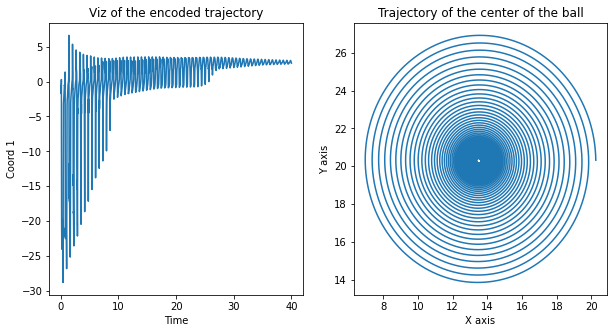

In [41]:
def plot_tsne_for_one_dim_latent(predicted_positions, positions):
    times = np.arange(0, frames*dt, dt)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(121)
    ax.plot(times, predicted_positions, '-')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coord 1')
    ax.set_title('Viz of the encoded trajectory')

    ax = fig.add_subplot(122)
    ax.plot(positions[:, 0], positions[:, 1], '-')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Trajectory of the center of the ball')
    plt.show()

jump = 1
plot_tsne_for_one_dim_latent(encoded_trajectory[::jump], positions[::jump])

# For the case latent = 2

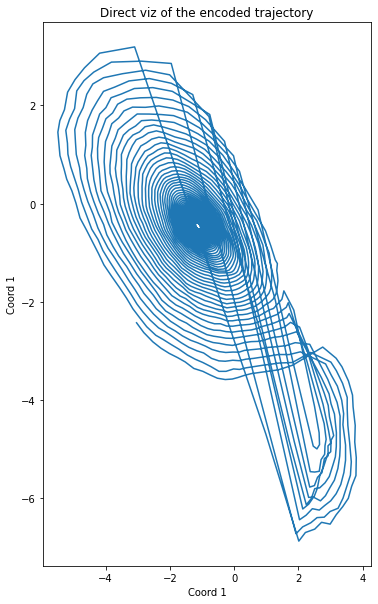

Text(0.5, 1.0, 'PaCMAP viz of the encoded trajectory')

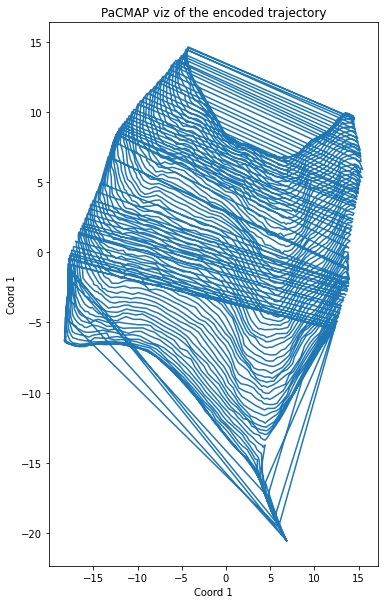

In [27]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(131)
ax.plot(encoded_whole_trajectory[:, 0], encoded_whole_trajectory[:, 1], '-')
ax.set_xlabel('Coord 1')
ax.set_ylabel('Coord 1')
ax.set_title('Direct viz of the encoded trajectory')
plt.show()

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(131)
ax.plot(pacmap_trajectory[:, 0], pacmap_trajectory[:, 1], '-')
ax.set_xlabel('Coord 1')
ax.set_ylabel('Coord 1')
ax.set_title('PaCMAP viz of the encoded trajectory')

In [13]:
encoded_whole_trajectory[:,1]

tensor([0., 0., 0.,  ..., 0., 0., 0.])